# Przygotowanie

In [1]:
import pandas as pd
import os
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gensim
import logging
from collections import defaultdict 
import tensorflow

Na początku zdefiniujmy sobie kilka zmiennych globalnych takich jak:
- DATASET_PATH - ścieżkę do pliku z tweetami
- W2V_MODEL_PATH - gdzie ma zostać zapisany model w2v

- DATASET_COLUMNS - nazwy kolumn
- DATASET_ENCODING - typ kodowaniu wykorzystany w naszym datasecie

In [2]:
from const import DATASET_PATH, W2V_MODEL_PATH, PREPROCESSED_TEST_PATH, PREPROCESSED_TRAIN_PATH
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

# Wczytanie danych

Możemy teraz wczytać nasz dataset. Jako, że tweety znajdują się w pliku `csv` możemy do tego użyć wbudowanej funkcji z bilbioteki `pandas`.

In [3]:
df = pd.read_csv(os.path.abspath(DATASET_PATH), encoding = DATASET_ENCODING , names = DATASET_COLUMNS)

Łatwo możemy sprawdzić z ilą danymi mamy tak naprawdę doczynienia:

In [4]:
df.shape

(1600000, 6)

Widmimy, że nasz zbiór danych składa się z 1600000 wierszy po 6 kolumn.

Wyświetlmy sobie teraz pierwsze 10 wierszy naszego setu:

In [5]:
df.head(10)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


Od razu widzimy, że niektóre z kolumn nam się nie przydadzą w dalszej analizie. Więc możemy spokojnie je usnąć.

In [6]:
df = df.drop(columns=["ids", "date", "flag", "user"])

Zostawiliśmy tylko dwie kolumny: `target` oraz `test`. Pierwsza z nich odpowiada emocją jakie niesie za sobą dany tweet. `0` oznacza negatywną wiadomość natomiast `4` odpowiada wiadomości pozytywnej. Teoreytcznie wartość `2` oznaczała by widomość neutralną. Jednak jak łatwo sprawdzić taka wartość nie występuje w tym zbiorze. 

In [7]:
df.target.unique()

array([0, 4], dtype=int64)

# Czyszczenie treści tweetów

Musimy oczyścić treść posów z:
- linków 
- nazw użytkowników
- znaków specjalnych
- hashtagów

W tym celu posłużymy się wyrażeniami regularnymi.

In [8]:
def get_clean_regex():
    users = "@\S+" # usuwa dowolne, niebiałe znaki po @ 
    links = "((www\.[^\s]+)|(https?://[^\s]+))" # usuwa linki
    not_alpha_numeric = "[^A-Za-z0-9]"
    hashtags = "#\S+" # usuwa dowolne, niebiałe znaki po #
    return "|".join([users, links, not_alpha_numeric, hashtags])
    

In [9]:
clean_regex = get_clean_regex()
print(clean_regex)

@\S+|((www\.[^\s]+)|(https?://[^\s]+))|[^A-Za-z0-9]|#\S+


In [10]:
df.text = df.text.apply(lambda x: re.sub(clean_regex, ' ', str(x).lower()).strip())

In [11]:
df.head(5).text

0    awww  that s a bummer   you shoulda got david ...
1    is upset that he can t update his facebook by ...
2    i dived many times for the ball  managed to sa...
3       my whole body feels itchy and like its on fire
4    no  it s not behaving at all  i m mad  why am ...
Name: text, dtype: object

In [12]:
df.text[0]

'awww  that s a bummer   you shoulda got david carr of third day to do it   d'

Całościowo wygląda dobrze, oprócz tego, że w tekscie teraz może występować wiele białych znaków obok siebie.

Dlatego, też musimy jeszcze wykonać jedną transformację na naszym zbiorze:

In [13]:
df.text = df.text.apply(lambda x: re.sub("\s+", ' ', str(x)).strip())

In [14]:
df.head(5).text

0    awww that s a bummer you shoulda got david car...
1    is upset that he can t update his facebook by ...
2    i dived many times for the ball managed to sav...
3       my whole body feels itchy and like its on fire
4    no it s not behaving at all i m mad why am i h...
Name: text, dtype: object

In [15]:
df.text[0]

'awww that s a bummer you shoulda got david carr of third day to do it d'

Warto jeszcze usunąc tak zwane **stop words** czyli słowa, których używamy ze względu na zasady gramatyczne i zwykle nie dodają znaczenia. Na przykład, są nimi: "the", "a", "an", "in. 

Moglibyśmy sami stworzyć słownik takich zwrotów. Jednak nie jest to wymagane, poniważ możemy skorzystać z gotowego rozwiązania.

In [16]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LukMcCall\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
def remove_stop_words(text, stop_words):
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(token)
    return " ".join(tokens)

df.text = df.text.apply(lambda x: remove_stop_words(str(x), stop_words).strip())

In [18]:
df.head(5).text

0         awww bummer shoulda got david carr third day
1    upset update facebook texting might cry result...
2    dived many times ball managed save 50 rest go ...
3                     whole body feels itchy like fire
4                                     behaving mad see
Name: text, dtype: object

In [19]:
df.head(5).text[0]

'awww bummer shoulda got david carr third day'

Możemy teraz zająć się labelami. Tu sprawda będzie prostsza. Musimy jednynie zamienić `4` na `1`.  

In [20]:
df.target = df.target.replace(4,1)

In [21]:
df.head

<bound method NDFrame.head of          target                                               text
0             0       awww bummer shoulda got david carr third day
1             0  upset update facebook texting might cry result...
2             0  dived many times ball managed save 50 rest go ...
3             0                   whole body feels itchy like fire
4             0                                   behaving mad see
...         ...                                                ...
1599995       1                      woke school best feeling ever
1599996       1           thewdb com cool hear old walt interviews
1599997       1                    ready mojo makeover ask details
1599998       1  happy 38th birthday boo alll time tupac amaru ...
1599999       1                               happy charitytuesday

[1600000 rows x 2 columns]>

# Charakterystyka danych

Dokonaliśmy już wstępnej obróbki danych. Jednak nie wiemy jeszcze jak wygląda rozkład labeli w naszym datasecie. 

In [22]:
df.target.value_counts()

1    800000
0    800000
Name: target, dtype: int64

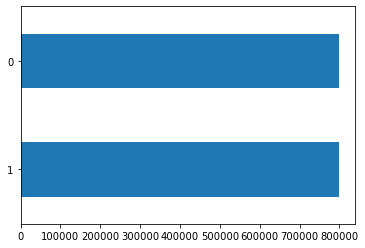

In [23]:
df.target.value_counts().sort_values().plot(kind = 'barh')

Już wiemy, że rozkład mamy tyle samo wiadomości pozytywnych co tych negatywnych.

Możemy jednocześnie policzyć jakie słowa występują najczęściej (oczywiście po wstępnym czyczeniu)

In [24]:
documents = [_text.split() for _text in df.text] 

def count_word_freq(document):
    count = defaultdict(int)
    for sentence in document:
        for s in sentence:
            count[s] += 1
    return count
count_word_freq = count_word_freq(documents)

In [25]:
word_freq_count_df = pd.DataFrame.from_dict(count_word_freq, orient='index', columns=["count"])
best_word_freq = word_freq_count_df.sort_values(by="count", ascending=False)[:10]
print(best_word_freq)

       count
good   91313
day    87072
get    82043
like   78565
go     73915
quot   71877
today  68219
work   64917
love   64687
going  64617


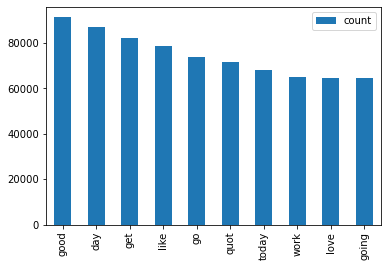

In [26]:
best_word_freq.plot(kind = 'bar')

# Podział na train i test

In [27]:
df_train, df_test = train_test_split(df, test_size = 0.2)
print("Podział danych")
print("  > Train: ", len(df_train))
print("  > Test: ", len(df_test))

Podział danych
  > Train:  1280000
  > Test:  320000


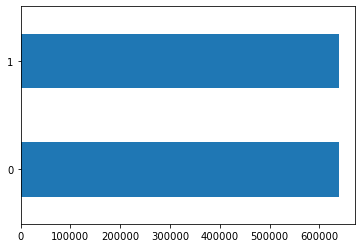

In [28]:
df_train.target.value_counts().plot(kind = 'barh')

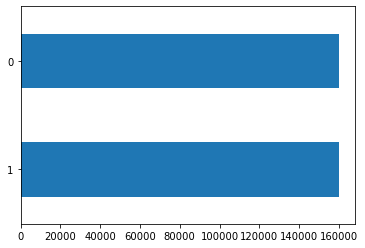

In [29]:
df_test.target.value_counts().plot(kind = 'barh')

# Word2Vec
Na podstawie https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial#Gensim-Word2Vec%C2%A0Tutorial

Następnym krokiem, który musismy wykonać jest zamiana słów na wektory. W tym celu posłużym się model zaimplementowanym w biliotece `gensim`. Model ten wykorzystuje prostą sieć neuronową.

Aby nasze dane były kompatybilne z tym algorytmem musimy zamienić je na listę list (każde znadnie jest zamienione na osobną listę).

In [32]:
documents = [_text.split() for _text in df_train.text] 

W celu monitorowania postępów dodamy loggera.

In [33]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level = logging.INFO)

Tworzymy teraz model podając kilka parametrów:
- __min_count__ - ignoruje słowa o mniejszej liczebności niż zadana
- __size__ - rozmar wyjściowych wektorów
- __window__ - maksymalny dystans pomiędzy słowami
- __alpha__ - learning rate
- __min_aplha__ - minimalna wartość learning ratu

In [34]:
w2v_model = gensim.models.word2vec.Word2Vec(min_count = 10,
                                            window = 7,
                                            size = 300,
                                            alpha = 0.03, 
                                            min_alpha = 0.0007, 
                                            workers = 7)

In [35]:
w2v_model.build_vocab(documents)

2020-06-06 01:29:34,701 : INFO : collecting all words and their counts
2020-06-06 01:29:34,702 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-06-06 01:29:34,734 : INFO : PROGRESS: at sentence #10000, processed 71276 words, keeping 13352 word types
2020-06-06 01:29:34,762 : INFO : PROGRESS: at sentence #20000, processed 143492 words, keeping 20379 word types
2020-06-06 01:29:34,791 : INFO : PROGRESS: at sentence #30000, processed 214782 words, keeping 25931 word types
2020-06-06 01:29:34,816 : INFO : PROGRESS: at sentence #40000, processed 286798 words, keeping 30896 word types
2020-06-06 01:29:34,839 : INFO : PROGRESS: at sentence #50000, processed 358394 words, keeping 35254 word types
2020-06-06 01:29:34,864 : INFO : PROGRESS: at sentence #60000, processed 429842 words, keeping 39384 word types
2020-06-06 01:29:34,890 : INFO : PROGRESS: at sentence #70000, processed 501447 words, keeping 43159 word types
2020-06-06 01:29:34,920 : INFO : PROGRESS: at s

2020-06-06 01:29:36,708 : INFO : PROGRESS: at sentence #720000, processed 5141056 words, keeping 172619 word types
2020-06-06 01:29:36,749 : INFO : PROGRESS: at sentence #730000, processed 5212459 words, keeping 174108 word types
2020-06-06 01:29:36,792 : INFO : PROGRESS: at sentence #740000, processed 5284007 words, keeping 175550 word types
2020-06-06 01:29:36,821 : INFO : PROGRESS: at sentence #750000, processed 5355597 words, keeping 176994 word types
2020-06-06 01:29:36,849 : INFO : PROGRESS: at sentence #760000, processed 5426738 words, keeping 178422 word types
2020-06-06 01:29:36,877 : INFO : PROGRESS: at sentence #770000, processed 5498144 words, keeping 179882 word types
2020-06-06 01:29:36,907 : INFO : PROGRESS: at sentence #780000, processed 5570256 words, keeping 181339 word types
2020-06-06 01:29:36,933 : INFO : PROGRESS: at sentence #790000, processed 5641723 words, keeping 182655 word types
2020-06-06 01:29:36,959 : INFO : PROGRESS: at sentence #800000, processed 571355

Możemy teraz wytrenować nasz model.

In [36]:
w2v_model.train(documents, total_examples=w2v_model.corpus_count, epochs=30)

2020-06-06 01:29:46,801 : INFO : training model with 7 workers on 30027 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-06-06 01:29:47,843 : INFO : EPOCH 1 - PROGRESS: at 11.15% examples, 901386 words/s, in_qsize 13, out_qsize 3
2020-06-06 01:29:48,847 : INFO : EPOCH 1 - PROGRESS: at 21.98% examples, 892889 words/s, in_qsize 12, out_qsize 1
2020-06-06 01:29:49,854 : INFO : EPOCH 1 - PROGRESS: at 33.46% examples, 906382 words/s, in_qsize 13, out_qsize 0
2020-06-06 01:29:50,892 : INFO : EPOCH 1 - PROGRESS: at 38.72% examples, 780597 words/s, in_qsize 14, out_qsize 0
2020-06-06 01:29:51,900 : INFO : EPOCH 1 - PROGRESS: at 46.27% examples, 747345 words/s, in_qsize 8, out_qsize 5
2020-06-06 01:29:52,919 : INFO : EPOCH 1 - PROGRESS: at 54.03% examples, 726847 words/s, in_qsize 14, out_qsize 0
2020-06-06 01:29:53,971 : INFO : EPOCH 1 - PROGRESS: at 61.02% examples, 699963 words/s, in_qsize 13, out_qsize 4
2020-06-06 01:29:54,988 : INFO : EPOCH 1 - PROGRESS: 

2020-06-06 01:30:34,100 : INFO : EPOCH 5 - PROGRESS: at 47.14% examples, 763746 words/s, in_qsize 13, out_qsize 0
2020-06-06 01:30:35,105 : INFO : EPOCH 5 - PROGRESS: at 57.42% examples, 775964 words/s, in_qsize 14, out_qsize 1
2020-06-06 01:30:36,112 : INFO : EPOCH 5 - PROGRESS: at 67.24% examples, 779547 words/s, in_qsize 14, out_qsize 1
2020-06-06 01:30:37,127 : INFO : EPOCH 5 - PROGRESS: at 77.42% examples, 784702 words/s, in_qsize 13, out_qsize 0
2020-06-06 01:30:38,160 : INFO : EPOCH 5 - PROGRESS: at 87.58% examples, 787179 words/s, in_qsize 13, out_qsize 0
2020-06-06 01:30:39,165 : INFO : EPOCH 5 - PROGRESS: at 97.00% examples, 785153 words/s, in_qsize 10, out_qsize 3
2020-06-06 01:30:39,359 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-06 01:30:39,378 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-06 01:30:39,385 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-06 01:30:39,388 : INFO : worker thr

2020-06-06 01:31:19,387 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-06 01:31:19,388 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-06 01:31:19,404 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-06 01:31:19,405 : INFO : EPOCH - 9 : training on 9140715 raw words (8193070 effective words) took 10.0s, 820888 effective words/s
2020-06-06 01:31:20,441 : INFO : EPOCH 10 - PROGRESS: at 8.41% examples, 675109 words/s, in_qsize 13, out_qsize 0
2020-06-06 01:31:21,474 : INFO : EPOCH 10 - PROGRESS: at 17.81% examples, 710578 words/s, in_qsize 14, out_qsize 0
2020-06-06 01:31:22,480 : INFO : EPOCH 10 - PROGRESS: at 28.10% examples, 752167 words/s, in_qsize 14, out_qsize 2
2020-06-06 01:31:23,488 : INFO : EPOCH 10 - PROGRESS: at 38.50% examples, 774913 words/s, in_qsize 12, out_qsize 1
2020-06-06 01:31:24,500 : INFO : EPOCH 10 - PROGRESS: at 49.09% examples, 791516 words/s, in_qsize 11, out_qsize 2
2020-06-06 01:3

2020-06-06 01:32:05,395 : INFO : EPOCH 14 - PROGRESS: at 37.84% examples, 770312 words/s, in_qsize 13, out_qsize 0
2020-06-06 01:32:06,398 : INFO : EPOCH 14 - PROGRESS: at 46.70% examples, 760965 words/s, in_qsize 13, out_qsize 0
2020-06-06 01:32:07,421 : INFO : EPOCH 14 - PROGRESS: at 56.10% examples, 759720 words/s, in_qsize 13, out_qsize 0
2020-06-06 01:32:08,440 : INFO : EPOCH 14 - PROGRESS: at 65.38% examples, 757814 words/s, in_qsize 13, out_qsize 0
2020-06-06 01:32:09,457 : INFO : EPOCH 14 - PROGRESS: at 74.47% examples, 754547 words/s, in_qsize 14, out_qsize 0
2020-06-06 01:32:10,461 : INFO : EPOCH 14 - PROGRESS: at 83.85% examples, 755911 words/s, in_qsize 13, out_qsize 0
2020-06-06 01:32:11,466 : INFO : EPOCH 14 - PROGRESS: at 93.05% examples, 755248 words/s, in_qsize 13, out_qsize 0
2020-06-06 01:32:12,145 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-06 01:32:12,148 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-06 01

2020-06-06 01:32:52,925 : INFO : EPOCH 18 - PROGRESS: at 80.25% examples, 714292 words/s, in_qsize 11, out_qsize 2
2020-06-06 01:32:53,940 : INFO : EPOCH 18 - PROGRESS: at 90.20% examples, 723116 words/s, in_qsize 13, out_qsize 0
2020-06-06 01:32:54,821 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-06 01:32:54,841 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-06 01:32:54,847 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-06 01:32:54,849 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-06 01:32:54,850 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-06 01:32:54,854 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-06 01:32:54,866 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-06 01:32:54,867 : INFO : EPOCH - 18 : training on 9140715 raw words (8191930 effective words) took 11.1s, 734817 effective wo

2020-06-06 01:33:36,702 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-06 01:33:36,706 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-06 01:33:36,709 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-06 01:33:36,715 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-06 01:33:36,716 : INFO : EPOCH - 22 : training on 9140715 raw words (8192023 effective words) took 10.3s, 792738 effective words/s
2020-06-06 01:33:37,736 : INFO : EPOCH 23 - PROGRESS: at 8.63% examples, 702618 words/s, in_qsize 13, out_qsize 0
2020-06-06 01:33:38,755 : INFO : EPOCH 23 - PROGRESS: at 17.59% examples, 711803 words/s, in_qsize 13, out_qsize 0
2020-06-06 01:33:39,774 : INFO : EPOCH 23 - PROGRESS: at 27.34% examples, 735351 words/s, in_qsize 12, out_qsize 1
2020-06-06 01:33:40,803 : INFO : EPOCH 23 - PROGRESS: at 37.08% examples, 745537 words/s, in_qsize 11, out_qsize 2
2020-06-06 01:33:41,809 : INFO : EPOCH

2020-06-06 01:34:22,848 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-06 01:34:22,861 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-06 01:34:22,862 : INFO : EPOCH - 26 : training on 9140715 raw words (8192225 effective words) took 13.0s, 630955 effective words/s
2020-06-06 01:34:23,880 : INFO : EPOCH 27 - PROGRESS: at 8.19% examples, 669602 words/s, in_qsize 11, out_qsize 4
2020-06-06 01:34:24,889 : INFO : EPOCH 27 - PROGRESS: at 18.91% examples, 770153 words/s, in_qsize 13, out_qsize 0
2020-06-06 01:34:25,923 : INFO : EPOCH 27 - PROGRESS: at 29.96% examples, 805588 words/s, in_qsize 13, out_qsize 0
2020-06-06 01:34:26,936 : INFO : EPOCH 27 - PROGRESS: at 39.81% examples, 803400 words/s, in_qsize 13, out_qsize 0
2020-06-06 01:34:27,953 : INFO : EPOCH 27 - PROGRESS: at 49.31% examples, 795936 words/s, in_qsize 12, out_qsize 1
2020-06-06 01:34:28,971 : INFO : EPOCH 27 - PROGRESS: at 59.93% examples, 805569 words/s, in_qsize 13, ou

(245791277, 274221450)

Aby zweryfikować jego działanie możemy wypisać podobne znaczeniowo słowa do danego wyrazu. Jeśli faktycznie będę podobne oznacza to, że mają one podobną reprezentację wektorową w naszym modelu - co chcieliśmy osiągnąć.

In [37]:
w2v_model.most_similar("dog")

C:\Users\LukMcCall\anaconda3\envs\sentimental140\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-06-06 01:35:03,579 : INFO : precomputing L2-norms of word weight vectors


[('dogs', 0.6410210728645325),
 ('puppy', 0.611770749092102),
 ('cat', 0.6063966751098633),
 ('doggy', 0.5756809711456299),
 ('kitty', 0.5448598861694336),
 ('doggie', 0.5443037748336792),
 ('kitten', 0.5287748575210571),
 ('chihuahua', 0.5141035318374634),
 ('pup', 0.512689471244812),
 ('yorkie', 0.4890669584274292)]

In [38]:
w2v_model.most_similar("cat")

C:\Users\LukMcCall\anaconda3\envs\sentimental140\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('kitten', 0.6162850856781006),
 ('dog', 0.6063966751098633),
 ('kitty', 0.5769404768943787),
 ('cats', 0.5112762451171875),
 ('kittens', 0.4878285527229309),
 ('stray', 0.4843490719795227),
 ('puppy', 0.47568947076797485),
 ('doggy', 0.47321197390556335),
 ('claws', 0.4446293115615845),
 ('kitties', 0.44060754776000977)]

# Zapisywanie

Odpowiedź dawane przez nasz model wyglądają dobrze. Dlatego też możemy zoptymalizować i zapisać nasz model.

In [39]:
w2v_model.init_sims(replace = True)
w2v_model.save(W2V_MODEL_PATH)

2020-06-06 01:35:03,691 : INFO : precomputing L2-norms of word weight vectors
2020-06-06 01:35:03,729 : INFO : saving Word2Vec object under W2V.model, separately None
2020-06-06 01:35:03,730 : INFO : not storing attribute vectors_norm
2020-06-06 01:35:03,730 : INFO : not storing attribute cum_table
2020-06-06 01:35:04,860 : INFO : saved W2V.model


Zapiszmy nasze przetworzone dane w formie `pickla`.

In [40]:
df_train.to_pickle(PREPROCESSED_TRAIN_PATH)
df_test.to_pickle(PREPROCESSED_TEST_PATH)